# Naive Bayes and NLP Modeling

In [1]:
from collections import defaultdict
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import nltk
from nltk.tokenize import regexp_tokenize, word_tokenize, RegexpTokenizer
from nltk.corpus import stopwords, wordnet
from nltk import pos_tag
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, precision_score, confusion_matrix

%load_ext autoreload
%autoreload 2

import os
import sys
module_path = os.path.abspath(os.pardir)
#print(module_path)
if module_path not in sys.path:
    sys.path.append(module_path)
    
from src.confusion import plot_confusion_matrix

## Learning Goals

- explain the use of Bayesian Reasoning for building NLP models
- describe Laplace Smoothing
- use `sklearn` and `nltk` to build NLP models

Before returning to our satire / no-satire example, let's consider an example with a smaller but similar scope.

Suppose we are using an API to gather articles from a news website and grabbing phrases from two different types of articles:  **music** and **politics**.

But we have a problem. Only some of our articles have an indication of their category (music or politics). Is there a way we can use Machine Learning to help us label our data **quickly**?

-------------------------------
### Here are our articles
#### Music Articles:

* 'the song was popular'
* 'band leaders disagreed on sound'
* 'played for a sold out arena stadium'

#### Politics Articles

* 'world leaders met lask week'
* 'the election was close'
* 'the officials agreed on a compromise'
--------------------------------------------------------
Let's try and predict one example phrase:

* "world leaders agreed to fund the stadium"

How can we make a model that labels this for us rather than having to go through by hand?

In [2]:
music = ['the song was popular',
         'band leaders disagreed on sound',
         'played for a sold out arena stadium']

politics = ['world leaders met last week',
            'the election was close',
            'the officials agreed on a compromise']

test_statement = 'world leaders agreed to fund the stadium'

In [3]:
#labels : {'music', 'politics'}
#features: words
test_statement_2 = 'officials met at the arena'

## Bayes's Theorem Again

Let's revisit Bayes's Theorem. Remember, the idea is to calculate the probability of the correct application of a class label (c) given some data (x). To do so, we calculate the **likelihood** (the distribution of our data within a given class) and the **prior** probabiliity of each class (the probability of seeing the class in the population). We are going generally to ignore the denominator of the right side of the equation because it will be constant.

<img src ="images/naive_bayes_icon.png">

### Another way of looking at it
<img src = "images/another_one.png">

## So, in the context of our problem......



$\large P(politics | phrase) = \frac{P(phrase|politics)P(politics)}{P(phrase)}$

$\large P(politics) = \frac{ \# politics}{\# all\ articles} $

*where phrase is our test statement*

<img src = "images/solving_theta.png" width="400">

### How should we calculate $P(politics)$?

This is essentially the distribution of the probability of either type of article. We have three of each type of article, therefore, we assume that there is an equal probability of either article

In [4]:
p_politics = len(politics) / (len(politics) + len(music))
p_music = len(music) / (len(politics) + len(music))

In [5]:
p_politics

0.5

In [6]:
p_music

0.5

### How should we calculate $P(phrase | politics)$?

We'll break the phrase down into individual words.

$\large P(phrase | politics) = \prod_{i=1}^{d} P(word_{i} | politics) $

**This is where the naivety of Naive Bayes comes in in this context. We assume that the predictive relevances of words are mutually independent.**

In practice, of course, this sounds rather unrealistic. But it greatly simplifies the Bayesian calculation.

$\large P(word_{i} | politics) = \frac{\#\ of\ word_{i}\ in\ politics\ articles} {\#\ of\ total\ words\ in\ politics\ articles} $

## Laplace Smoothing

In practice, the calculation of probabilities is often adjusted slightly to avoid zeroes.

$\large P(word_{i} | politics) = \frac{\#\ of\ word_{i}\ in\ politics\ articles \bf{+ \alpha}} {\#\ of\ total\ words\ in\ politics\ articles \bf{+ \alpha d}} $

$\large P(word_{i} | music) = \frac{\#\ of\ word_{i}\ in\ music\ articles \bf{+ \alpha}} {\#\ of\ total\ words\ in\ music\ articles \bf{+ \alpha d}}$

This correction process is called Laplace smoothing:

* d : number of features (in this instance total number of vocabulary words)
* $\alpha$ can be any number greater than 0 (it is usually 1)


#### Now let's find this calculation

In [7]:
def vocab_maker(category):
    """
    parameters: category is a list containing all the articles
    of a given category.
    
    returns the vocabulary for a given type of article
    
    """
    
    vocab_category = set() # will filter down to only unique words
    
    for art in category:
        words = art.split()
        for word in words:
            vocab_category.add(word)
    return vocab_category

In [8]:
voc_music = vocab_maker(music)
voc_pol = vocab_maker(politics)

In [9]:
# These are all the unique words in the music category
voc_music

{'a',
 'arena',
 'band',
 'disagreed',
 'for',
 'leaders',
 'on',
 'out',
 'played',
 'popular',
 'sold',
 'song',
 'sound',
 'stadium',
 'the',
 'was'}

In [10]:
# These are all the unique words in the politics category
voc_pol

{'a',
 'agreed',
 'close',
 'compromise',
 'election',
 'last',
 'leaders',
 'met',
 'officials',
 'on',
 'the',
 'was',
 'week',
 'world'}

In [11]:
# The union of the two sets gives us the unique words across both article groups
voc_all = voc_music.union(voc_pol)
voc_all

{'a',
 'agreed',
 'arena',
 'band',
 'close',
 'compromise',
 'disagreed',
 'election',
 'for',
 'last',
 'leaders',
 'met',
 'officials',
 'on',
 'out',
 'played',
 'popular',
 'sold',
 'song',
 'sound',
 'stadium',
 'the',
 'was',
 'week',
 'world'}

In [12]:
total_vocab_count = len(voc_all)
total_music_count = len(voc_music)
total_politics_count = len(voc_pol)

Let's remind ourselves of the goal, to see the posterior probability of the class politics given our phrase. 

> P(politics | "leaders agreed to fund the stadium")

In [13]:
def find_number_words_in_category(phrase, category):
    
    """This function will help us calculate our likelihoods
    by constructing a dictionary of counts of how many times
    each word in our test phrase appears in articles of a
    given category."""
    
    statement = phrase.split()
    
    # category is a list of the raw documents of each category
    str_category = ' '.join(category)
    cat_word_list = str_category.split()
    word_count = defaultdict(int)
    
    # loop through each word in the phrase
    for word in statement:
        # loop through each word in the category
        for art_word in cat_word_list:
            if word == art_word:
                # count the number of times the phrase word occurs in the category
                word_count[word] += 1
            else:
                word_count[word]
    return word_count

In [14]:
test_music_word_count = find_number_words_in_category(test_statement, music)

In [18]:
test_politic_word_count = find_number_words_in_category(test_statement, politics)

Let's remind ourselves of our music articles:

In [15]:
music

['the song was popular',
 'band leaders disagreed on sound',
 'played for a sold out arena stadium']

Let's remind ourselves of our politics articles:

In [16]:
politics

['world leaders met last week',
 'the election was close',
 'the officials agreed on a compromise']

In [17]:
def find_likelihood_with_smooth(category_count, test_category_count, alpha):
    
    # The numerator will be the product of all the counts 
    # with the smoothing factor (alpha) to make sure the probability is not zeroed out.
    # Because we're being officially "naïve", we'll simply multiply these all together.
    num = np.product(np.array(list(test_category_count.values())) + alpha)
    
    # The denominator will be the same for each word (total category count + total vocab
    # + alpha), so we raise it to the power of the length of the test category (d =
    # total_vocab_count)
    denom = (category_count + total_vocab_count*alpha)**(len(test_category_count))
    
    return num / denom

In [19]:
likelihood_m = find_likelihood_with_smooth(total_music_count, test_music_word_count, 1)

In [20]:
likelihood_p = find_likelihood_with_smooth(total_politics_count, test_politic_word_count, 1)

In [21]:
print(likelihood_m)
print(likelihood_p)

4.107740405680756e-11
1.748875897714495e-10


 $ P(politics | article) = P(politics) x \prod_{i=1}^{d} P(word_{i} | politics) $

#### Deteriming the winner of our model:

<img src = "images/solvingforyhat.png" width= "400">

In [22]:
# p(politics|article)  > p(music|article)
likelihood_p * p_politics  > likelihood_m * p_music

True

Many times, the probabilities we end up with are exceedingly small, so we can transform them using logarithms to save on computation speed. This takes advantage of the nice mathematical feature that the log of a product of factors is equal to the sum of the logs of the individual factors, i.e.:

$log(xy) = log(x) + log(y)$

$\large log(P(politics | article)) = log(P(politics)) + \sum_{i=1}^{d}log( P(word_{i} | politics)) $





Good Resource: https://nlp.stanford.edu/IR-book/html/htmledition/naive-bayes-text-classification-1.html

## Back to Satire

In [23]:
corpus = pd.read_csv('data/satire_nosatire.csv')
corpus.head()

,body,target
0,Noting that the resignation of James Mattis as...,1
1,Desperate to unwind after months of nonstop wo...,1
2,"Nearly halfway through his presidential term, ...",1
3,Attempting to make amends for gross abuses of ...,1
4,Decrying the Senate’s resolution blaming the c...,1


Like always, we will perform a train test split...

In [24]:
X = corpus.body
y = corpus.target

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    random_state=42,
                                                    test_size=0.25)

... and preprocess the training set.

In [26]:
# Bring in stopwords

sw = stopwords.words('english')

In [27]:
def get_wordnet_pos(treebank_tag):
    '''
    Translate nltk POS to wordnet tags
    '''
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

In [28]:
def doc_preparer(doc, stop_words=sw):
    '''
    
    :param doc: a document from the satire corpus 
    :return: a document string with words which have been 
            lemmatized, 
            parsed for stopwords, 
            made lowercase,
            and stripped of punctuation and numbers.
    '''
    
    regex_token = RegexpTokenizer(r"([a-zA-Z]+(?:’[a-z]+)?)")
    doc = regex_token.tokenize(doc)
    doc = [word.lower() for word in doc]
    doc = [word for word in doc if word not in sw]
    # print(doc)
    doc = pos_tag(doc)
    doc = [(word[0], get_wordnet_pos(word[1])) for word in doc]
    lemmatizer = WordNetLemmatizer() 
    doc = [lemmatizer.lemmatize(word[0], word[1]) for word in doc]
    return ' '.join(doc)

In [29]:
token_docs = [doc_preparer(doc, sw) for doc in X_train]

For demonstration purposes, we will **limit our count vectorizer to 5 words** (the top 5 words by frequency).

In [30]:
# Secondary train-test split to build our best model
X_t, X_val, y_t, y_val = train_test_split(token_docs, y_train,
                                          test_size=0.25, random_state=42)

In [31]:
cv = CountVectorizer(max_features=5)

X_t_vec = cv.fit_transform(X_t)
X_t_vec = pd.DataFrame.sparse.from_spmatrix(X_t_vec)
X_t_vec.columns = sorted(cv.vocabulary_)
X_t_vec.set_index(y_t.index, inplace=True)

In [32]:
X_t_vec

,one,people,say,would,year
159,2,3,0,1,0
246,3,1,0,2,1
640,0,0,5,0,4
809,2,2,10,1,7
130,1,0,0,4,0
...,...,...,...,...,...
148,1,1,1,3,1
300,0,0,1,1,0
356,4,1,3,4,0
36,4,1,6,3,3


In [33]:
# We then transform the validation set. (Do not refit the vectorizer!)

X_val_vec = cv.transform(X_val)
X_val_vec  = pd.DataFrame.sparse.from_spmatrix(X_val_vec)
X_val_vec.columns = sorted(cv.vocabulary_)
X_val_vec.set_index(y_val.index, inplace=True)

## Multinomial Naive Bayes

Now let's fit the the Multinomial Naive Bayes Classifier on our training data

In [34]:
mnb = MultinomialNB()

mnb.fit(X_t_vec, y_t)

MultinomialNB()

Generate model predictions and get an accuracy score!

In [35]:
y_hat = mnb.predict(X_val_vec)

In [36]:
accuracy_score(y_val, y_hat)

0.9095744680851063

Let's consider the scenario that we would like to isolate satirical news on Facebook so we can flag it. We do not want to flag real news by mistake. In other words, we want to minimize false positives.

Confusion Matrix, without normalization
[[91  8]
 [ 9 80]]


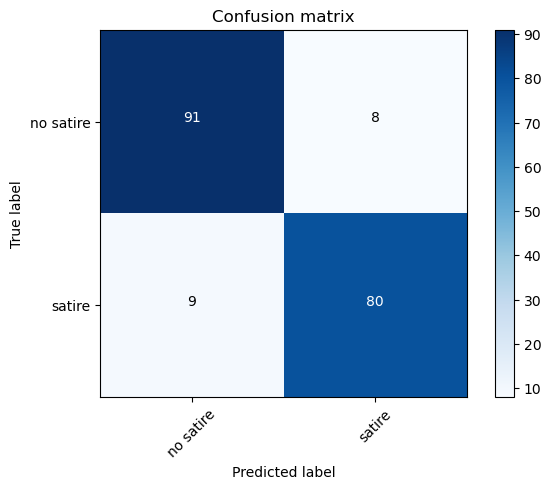

In [37]:
cm = confusion_matrix(y_val, y_hat)
plot_confusion_matrix(cm, classes=['no satire', 'satire'])

That's pretty good for a five word vocabulary.

Let's see what happens when we don't restrict our vocabulary.

In [38]:
# CV
cv = CountVectorizer()
X_t_vec = cv.fit_transform(X_t)
X_t_vec = pd.DataFrame.sparse.from_spmatrix(X_t_vec)
X_t_vec.columns = sorted(cv.vocabulary_)
X_t_vec.set_index(y_t.index, inplace=True)

X_val_vec = cv.transform(X_val)
X_val_vec = pd.DataFrame.sparse.from_spmatrix(X_val_vec)
X_val_vec.columns = sorted(cv.vocabulary_)
X_val_vec.set_index(y_val.index, inplace=True)

Confusion Matrix, without normalization
[[95  4]
 [ 4 85]]


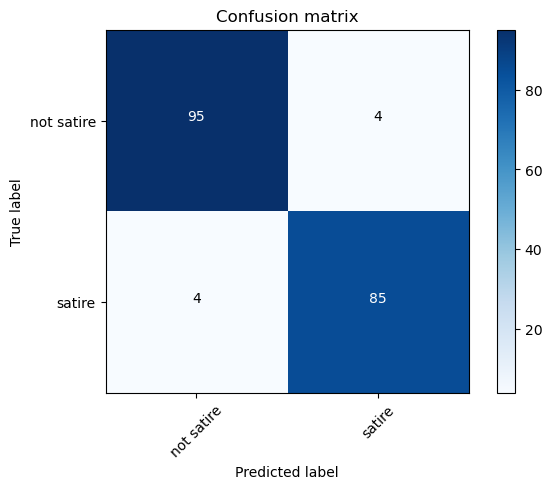

In [39]:
# MNB
mnb = MultinomialNB()

mnb.fit(X_t_vec, y_t)
y_hat = mnb.predict(X_val_vec)
cm2 = confusion_matrix(y_val, y_hat)
plot_confusion_matrix(cm2, classes=['not satire', 'satire'])

Wow! Look how well that performed. 

In [40]:
# Metrics
accuracy_score(y_val, y_hat)

0.9574468085106383

In [41]:
precision_score(y_val, y_hat)

0.9550561797752809

Let's see whether or not we can maintain that level of accuracy with fewer words.

In [42]:
len(cv.vocabulary_)

14834

In [43]:
cv = CountVectorizer(min_df=0.05, max_df=0.95)
X_t_vec = cv.fit_transform(X_t)

X_val_vec = cv.transform(X_val)

mnb = MultinomialNB()

mnb.fit(X_t_vec, y_t)
y_hat = mnb.predict(X_val_vec)

precision_score(y_val, y_hat)

0.9425287356321839

In [44]:
len(cv.vocabulary_)

651

In [ ]:
# Now let's see what happens with TF-IDF

In [51]:
tfidf = TfidfVectorizer()
X_t_vec = tfidf.fit_transform(X_t)

X_val_vec = tfidf.transform(X_val)

mnb = MultinomialNB()

mnb.fit(X_t_vec, y_t)
y_hat = mnb.predict(X_val_vec)

precision_score(y_val, y_hat)

0.9444444444444444

Confusion Matrix, without normalization
[[94  5]
 [ 4 85]]


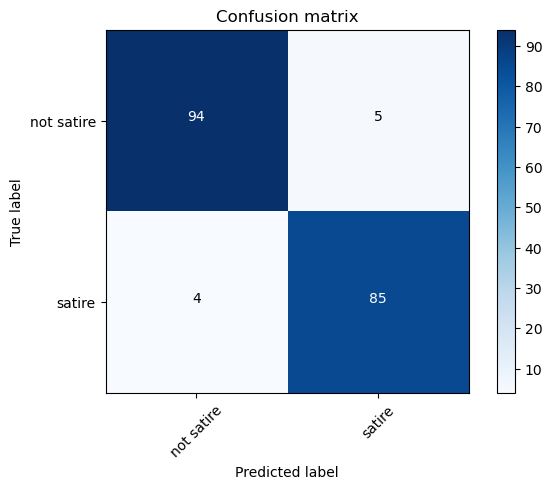

In [52]:
cm3 = confusion_matrix(y_val, y_hat)
plot_confusion_matrix(cm3, classes=['not satire', 'satire'])

TFIDF does not necessarily perform better than CV. It is just a tool in our toolbelt that's often worth trying out.

In [53]:
len(tfidf.vocabulary_)

14834

In [54]:
tfidf = TfidfVectorizer(min_df=0.05, max_df=0.95)
X_t_vec = tfidf.fit_transform(X_t)

X_val_vec = tfidf.transform(X_val)

mnb = MultinomialNB()

mnb.fit(X_t_vec, y_t)
y_hat = mnb.predict(X_val_vec)

precision_score(y_val, y_hat)

0.9651162790697675

Confusion Matrix, without normalization
[[96  3]
 [ 6 83]]


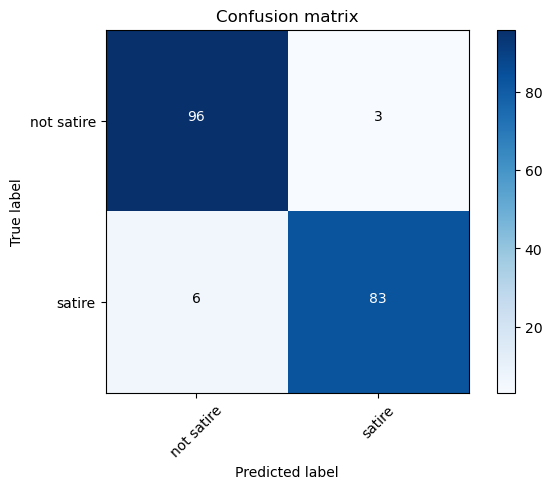

In [50]:
cm4 = confusion_matrix(y_val, y_hat)
plot_confusion_matrix(cm4, classes=['not satire', 'satire'])

In [55]:
len(tfidf.vocabulary_)

651

Let's compare MNB to Random Forest:

In [59]:
#takes longer than MNB
rf = RandomForestClassifier(n_estimators=1000)
rf.fit(X_t_vec, y_t)
y_hat = rf.predict(X_val_vec)
precision_score(y_val, y_hat)

0.9560439560439561

The two perform comparably, but MNB is lightweight as far as computational power and speed. For real-time predictions, we may choose MNB over Random Forest because the classifications can be performed quickly.